In [21]:
import optuna
import synergy_dataset as sd
from asreview.models.balancers import Balanced
from asreview.models.classifiers import NaiveBayes
from asreview.models.queriers import Max
from asreview.models.feature_extractors import Tfidf
import asreview
import pandas as pd
import numpy as np

# Path to your SQLite3 database
db_path = ""

In [22]:
def pad_labels(labels, num_priors, num_records):
    return pd.Series(labels.tolist() + np.zeros(num_records - len(labels) - num_priors).tolist())

In [23]:
study = {"dataset_id": "Leenaars_2019", "prior_inclusions": [2579, 16, 27], "prior_exclusions": [1868]}
#X = sd.Dataset("Meijboom_2021").to_frame().reset_index()
#X = sd.Dataset("Radjenovic_2013").to_frame().reset_index()
X = sd.Dataset(study["dataset_id"]).to_frame().reset_index()
priors = study["prior_inclusions"] + study["prior_exclusions"]
#priors = [122, 1534, 1283] #smid
#priors = [1960, 2771, 1632, 5899] #rad
#priors = [282, 15, 772] #meij
#priors = [531, 434, 129, 119, 437, 362] #meij
labels = X["label_included"]

In [24]:
study_name = "ASReview2-full-tfidf-nb-3"
study = optuna.load_study(study_name=study_name, storage=db_path)
params = study.best_trial.params

alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=NaiveBayes(alpha=params["nb__alpha"]),
    balancer=Balanced(ratio=params['ratio']),
    feature_extractor=Tfidf(stop_words=None, ngram_range=(1, 2), sublinear_tf=True, max_df=params["tfidf__max_df"], min_df=params["tfidf__min_df"]),
)
simulate_ndcg = asreview.Simulate(
    X=X,
    labels=labels,
    cycles=[alc],
)
# Set priors
simulate_ndcg.label(priors)
# Start simulation
simulate_ndcg.review()


df_ndcg = simulate_ndcg._results.dropna(axis=0, subset="training_set")
labels_ndcg = pad_labels(df_ndcg["label"].reset_index(drop=True), len(priors), len(X))
recall_ndcg = labels_ndcg.cumsum()

Records labeled       :   2%|▏         | 93/5812 [00:04<04:57, 19.24it/s]


Loss: 0.002
NDCG: 0.878


In [25]:
study_name = "ASReview2-full-nb-1"
study = optuna.load_study(study_name=study_name, storage=db_path)
params = study.best_trial.params

alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=NaiveBayes(alpha=params["alpha"]),
    balancer=Balanced(ratio=params['ratio']),
    feature_extractor=Tfidf(stop_words=None, ngram_range=(1, 2), sublinear_tf=True, max_df=params["tfidf__max_df"], min_df=params["tfidf__min_df"]),
)
simulate_loss = asreview.Simulate(
    X=X,
    labels=labels,
    cycles=[alc],
)
# Set priors
simulate_loss.label(priors)
# Start simulation
simulate_loss.review()

df_loss = simulate_loss._results.dropna(axis=0, subset="training_set")
labels_loss = pad_labels(df_loss["label"].reset_index(drop=True), len(priors), len(X))
recall_loss = labels_loss.cumsum()

Records labeled       :   2%|▏         | 102/5812 [00:02<02:39, 35.74it/s]


Loss: 0.003
NDCG: 0.869


In [26]:
alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=NaiveBayes(alpha=3.822),
    balancer=Balanced(ratio=1.2),
    feature_extractor=Tfidf(stop_words='english', ngram_range=(1, 1)),
)
simulate_old = asreview.Simulate(
    X=X,
    labels=labels,
    cycles=[alc],
)
# Set priors
simulate_old.label(priors)
# Start simulation
simulate_old.review()

df_old = simulate_old._results.dropna(axis=0, subset="training_set")
labels_old = pad_labels(df_old["label"].reset_index(drop=True), len(priors), len(X))
recall_old = labels_old.cumsum()

Records labeled       :   2%|▏         | 128/5812 [00:01<01:04, 88.28it/s] 


Loss: 0.003
NDCG: 0.895


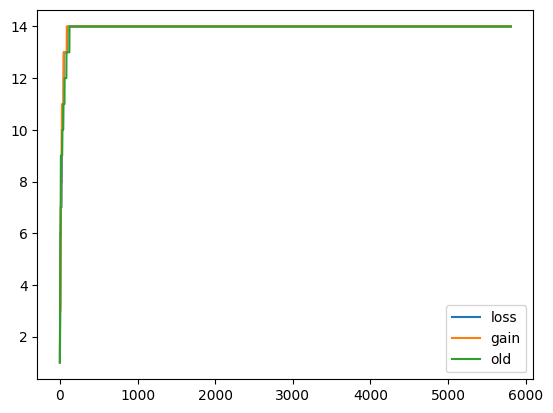

In [29]:
import matplotlib.pyplot as plt
combined = pd.DataFrame({"loss": recall_loss, "gain": recall_ndcg, "old": recall_old}) 

combined.plot()
plt.savefig("recall_comp.pdf")